# Time Series Project <a id='intro'></a>

## Project Description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions
1) Download the data and resample it by one hour.
2) Analyze the data.
3) Train different models with different hyperparameters. The test sample should be 10% of the initial dataset.
4) Test the data using the test sample and provide a conclusion.

## Data description
The dataset is stored in the `/datasets/taxi.csv` file.

The number of orders is in the 'num_orders' column.

## Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from pmdarima import auto_arima


## Load Data

In [2]:
def load_data(file_name, local_path, server_path):
    try:
        data = pd.read_csv(local_path + file_name)
        print(f"'{file_name}' file successfully read from the local path.")

    except FileNotFoundError:
        try:
            data = pd.read_csv(server_path + file_name)
            print(f"'{file_name}' file successfully read from the server path.")

        except FileNotFoundError:
            print(f"'{file_name}' file not found. Please check the file paths.")
            data = None
            
    return data

file_name = 'taxi.csv'
local_path = '/Users/benjaminstephen/Documents/TripleTen/Sprint_13/Time_Series_Project/datasets/'
server_path = '/datasets/'

data = load_data(file_name, local_path, server_path)

'taxi.csv' file successfully read from the local path.


## Preparation

To start, we will conduct basic exploratory data analysis and resample the data to ensure it is optimally prepared for time series analysis.

In [3]:
display(data)
print("DATA BASIC INFO:")
print("----------------")
print(data.info())
print()
print("NUMBER OF DUPLICATED ROWS:", data.duplicated().sum())

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


DATA BASIC INFO:
----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None

NUMBER OF DUPLICATED ROWS: 0



The dataset comprises 26,496 entries with timestamps and corresponding order counts, spanning from March 1, 2018, to August 31, 2018. The 'datetime' column is currently an object and should be converted to a 'datetime' type for time series analysis. The 'num_orders' column, which contains integer values representing the number of orders at each timestamp, is complete with no missing or duplicated entries. The absence of duplicates and non-null values indicates a clean dataset.

We will proceed by converting the 'datetime' column to a 'datetime' type and setting it as the index of the dataset. Following this, the data will be resampled to an hourly frequency to aggregate the order counts.

In [4]:
# Convert the 'datetime' column to datetime type
data['datetime'] = pd.to_datetime(data['datetime'])

# Set the 'datetime' column as the index
data.set_index('datetime', inplace=True)

# Resample the data by 1 hour
data_resampled = data.resample('1H').sum()

display(data_resampled)
print("RESAMPLED DATA BASIC INFO:")
print("--------------------------")
print(data_resampled.info())
print()
print("IS DATA MONOTONIC INCREASING?:", data_resampled.index.is_monotonic_increasing)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


RESAMPLED DATA BASIC INFO:
--------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB
None

IS DATA MONOTONIC INCREASING?: True


The data is now aggregated at an hourly frequency, which simplifies the dataset while retaining key information. The 'num_orders' column contains integer values and is complete, with no missing data. The dataset is confirmed to be monotonic increasing, indicating that the timestamps are in the correct chronological order without any gaps or irregularities. This hourly aggregation facilitates smoother trend analysis and model application by reducing the volume and noise of the original high-frequency data.

## Analysis

We will apply rolling window analysis to the hourly resampled dataset to compute the rolling mean. The rolling mean helps to smooth out short-term fluctuations and reveal longer-term trends. By creating a 24-hour rolling window, the code calculates the average and variability of the 'num_orders' over the past 24 hours for each data point.

<Axes: xlabel='datetime'>

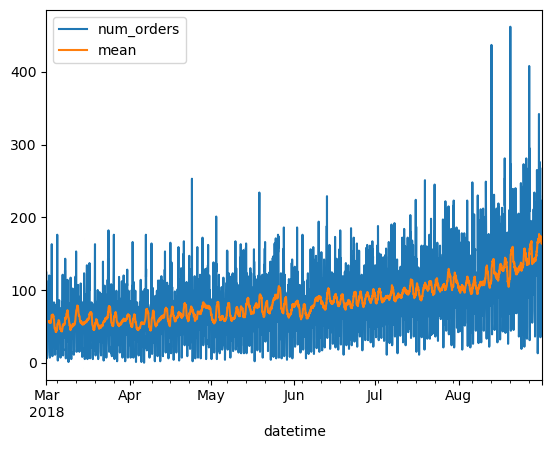

In [5]:
data_rolling = data_resampled.copy()

# Define the size of the rolling window
rolling_mean_size = 24

# Calculate the rolling mean of 'num_orders' over a 24-hour window
data_rolling['mean'] = data_rolling['num_orders'].rolling(rolling_mean_size).mean()

data_rolling.plot()

The upward trend in the rolling mean observed in the plot indicates a growing trend in Sweet Lift Taxi demand at airports. This increase could be attributed to various factors, such as changes in consumer behavior, effective marketing strategies, or seasonal fluctuations.

Let's analyze the time series on a monthly basis by decomposing each month's data into its individual components: original, trend, and seasonal. This approach will provide a more detailed understanding of the underlying patterns and trends within our time series.

In [6]:
# Decompose the time series into its components
decomposed = seasonal_decompose(data_resampled['num_orders'])

# Plot the time series decomposition components by month
def plot_decomposition(start_date, end_date):
    plt.figure(figsize=(20, 8))

    # Plot the original data in the first subplot
    plt.subplot(311)
    data_resampled[start_date:end_date].plot(ax=plt.gca())
    plt.title('Original')

    # Plot the trend component in the second subplot
    plt.subplot(312)
    decomposed.trend[start_date:end_date].plot(ax=plt.gca())
    plt.title('Trend')

     # Plot the seasonal component in the third subplot
    plt.subplot(313)
    decomposed.seasonal[start_date:end_date].plot(ax=plt.gca())
    plt.title('Seasonality')

    plt.tight_layout()
    plt.show()

### March Decomposition

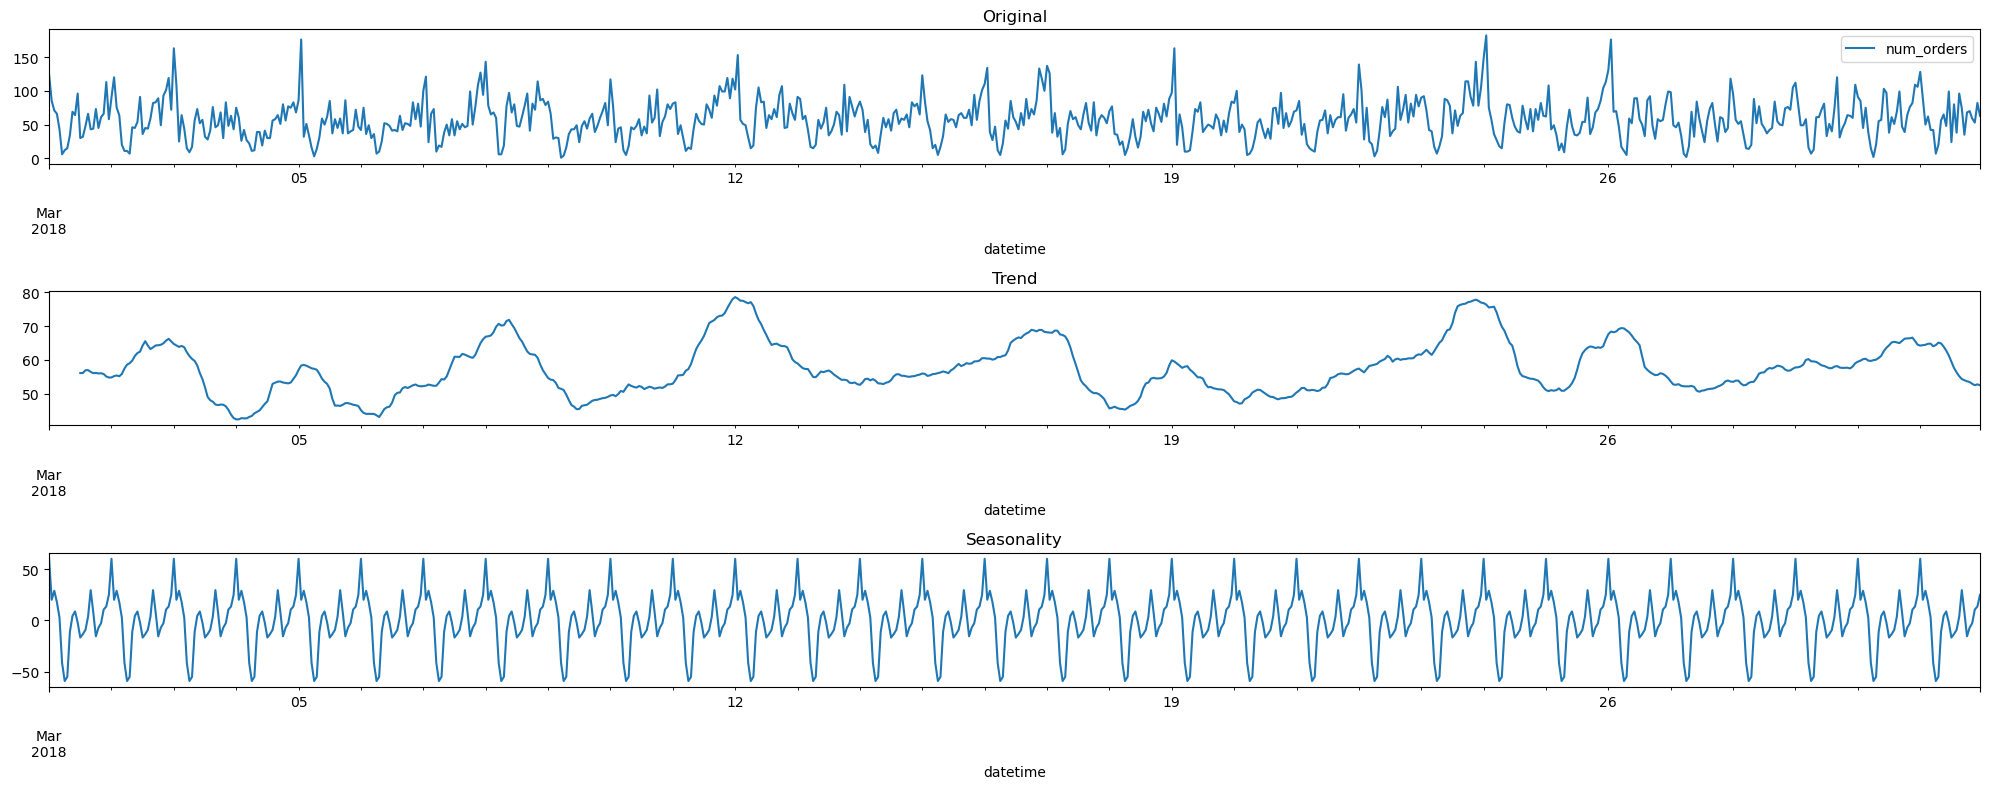

In [7]:
plot_decomposition('2018-03-01', '2018-03-31')

### April Decomposition

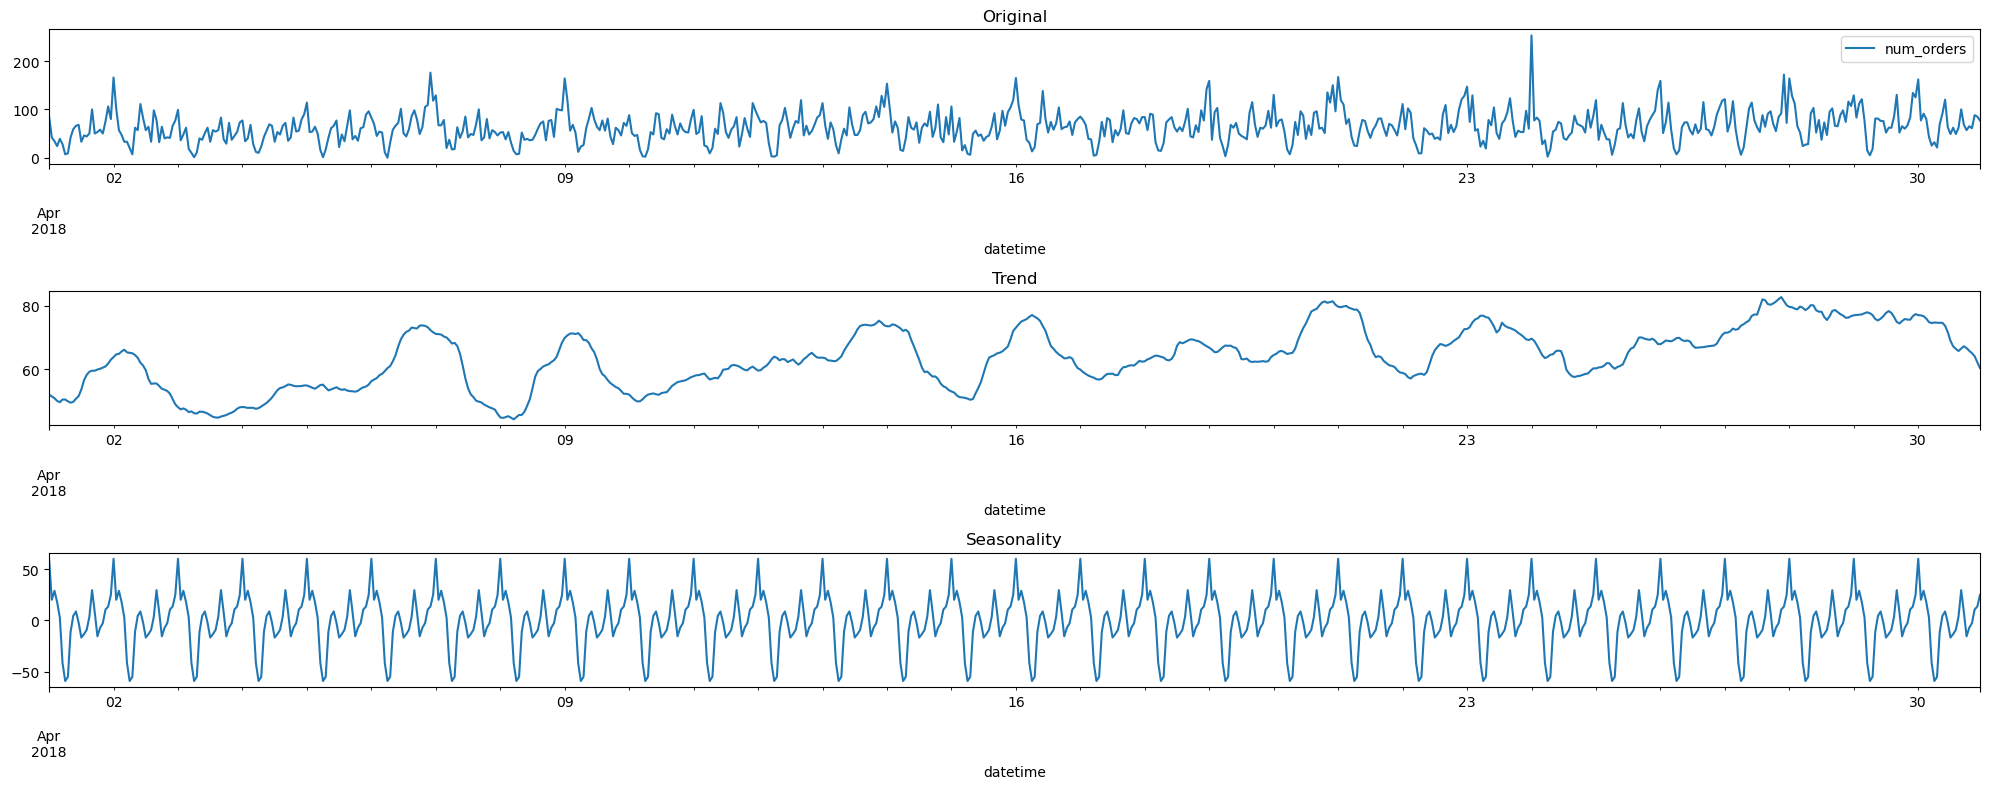

In [8]:
plot_decomposition('2018-04-01', '2018-04-30')

### May Decomposition

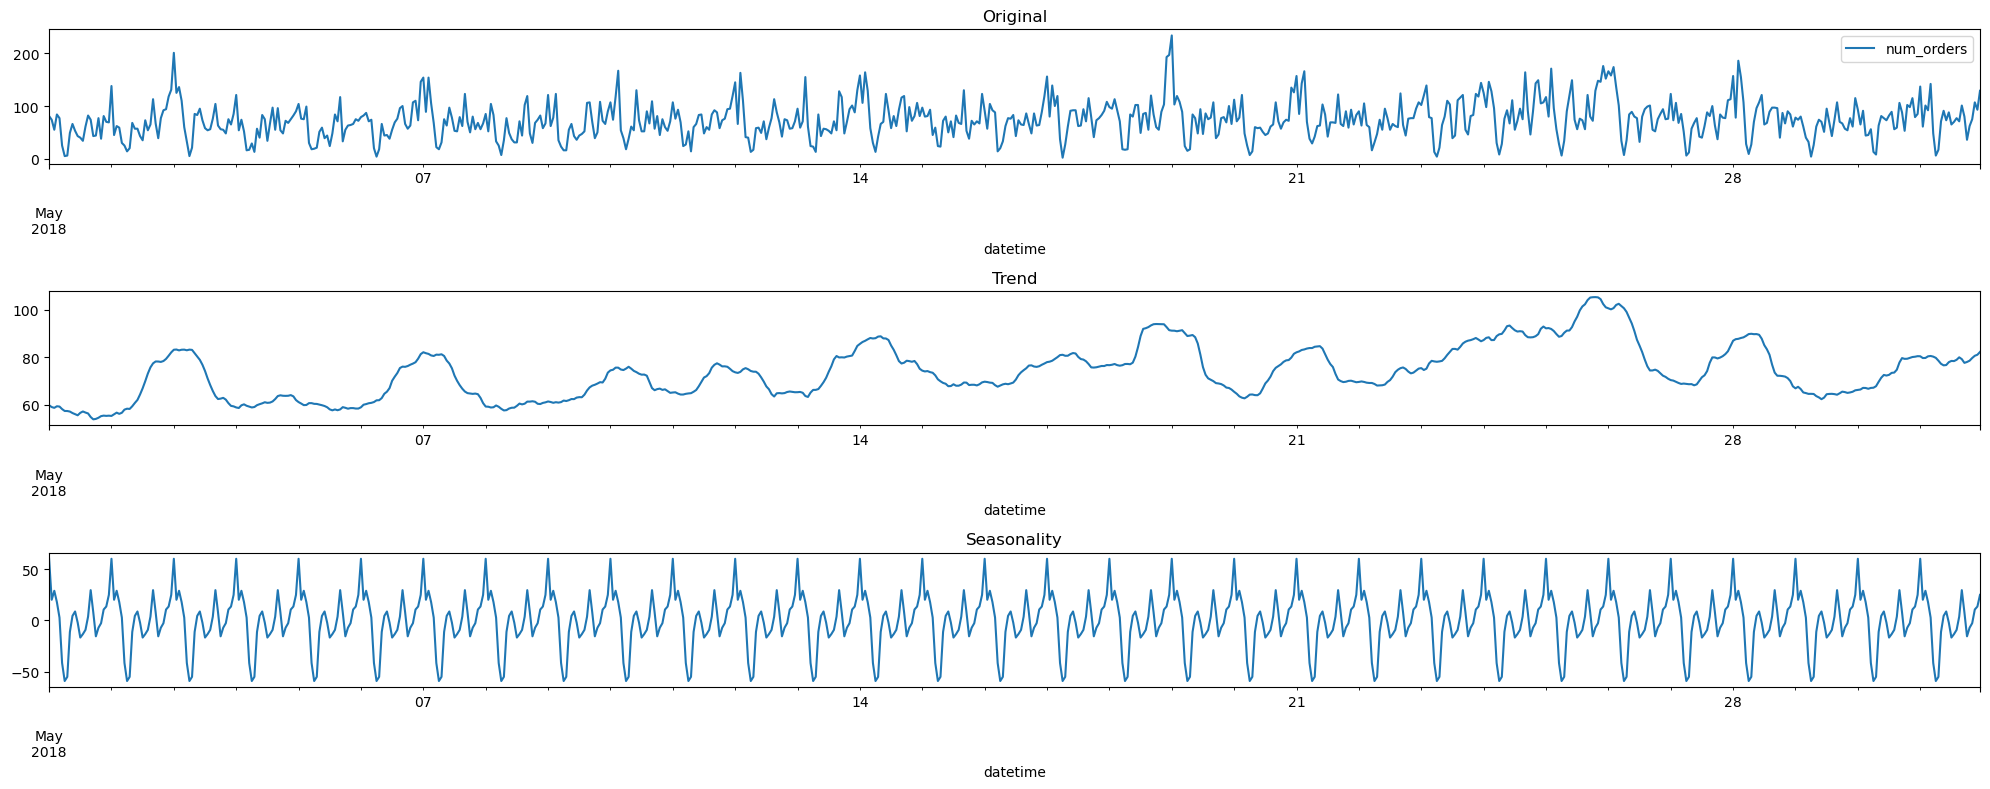

In [9]:
plot_decomposition('2018-05-01','2018-05-31')

### June Decomposition

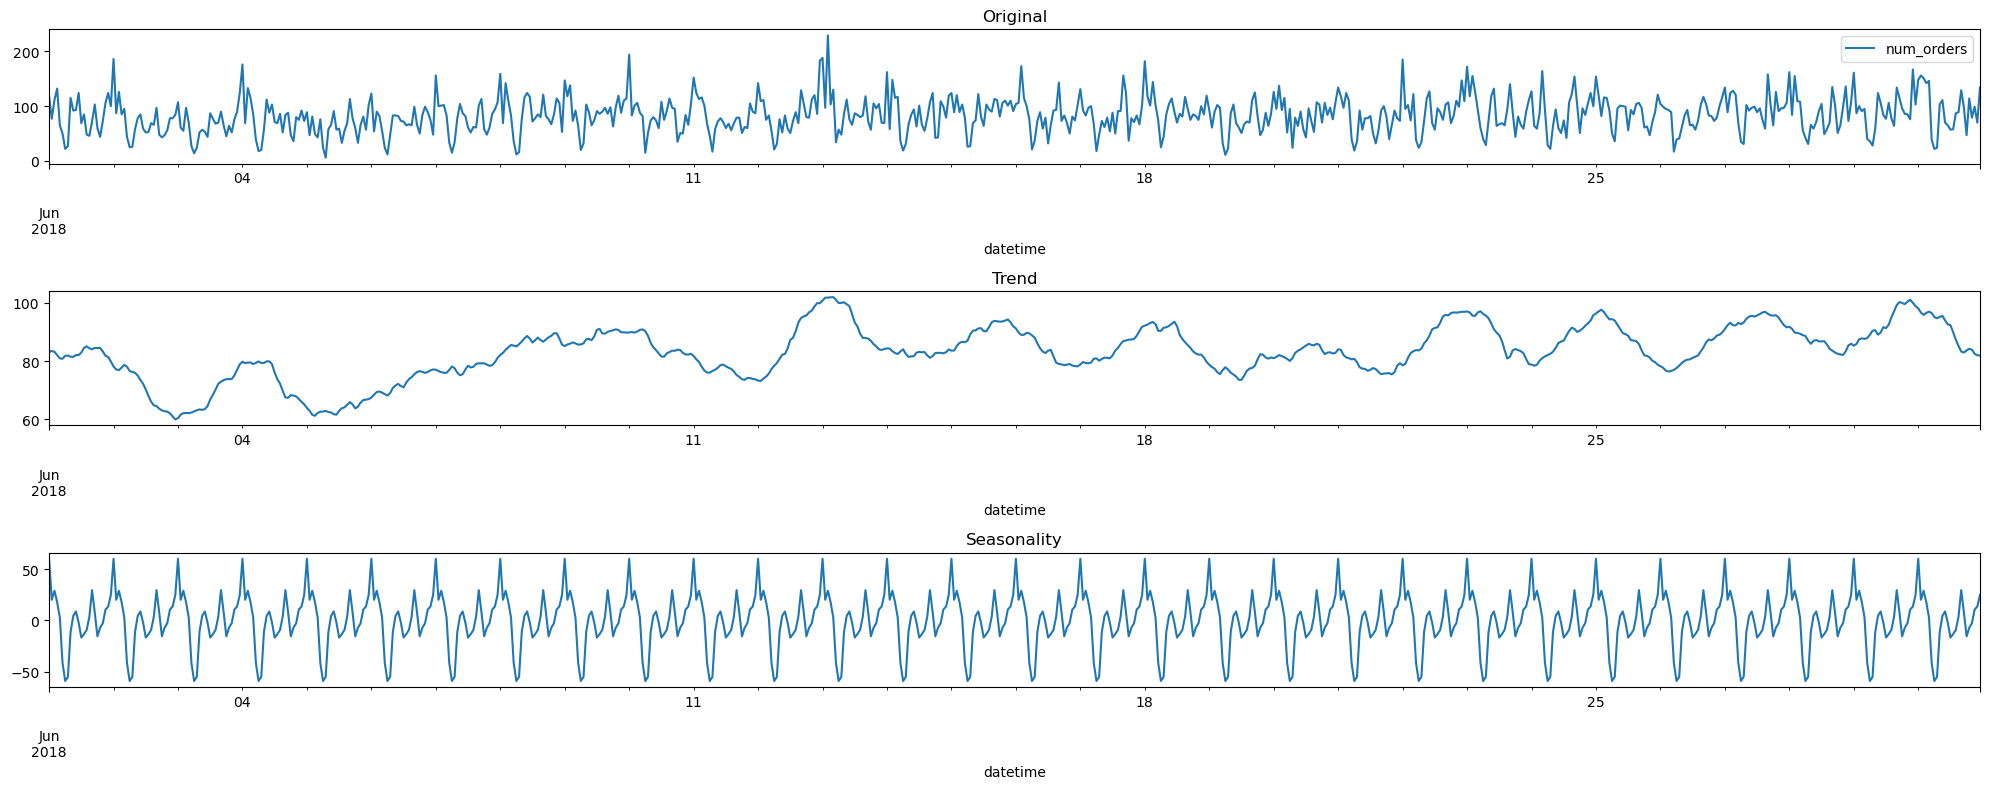

In [10]:
plot_decomposition('2018-06-01','2018-06-30')

### July Decomposition

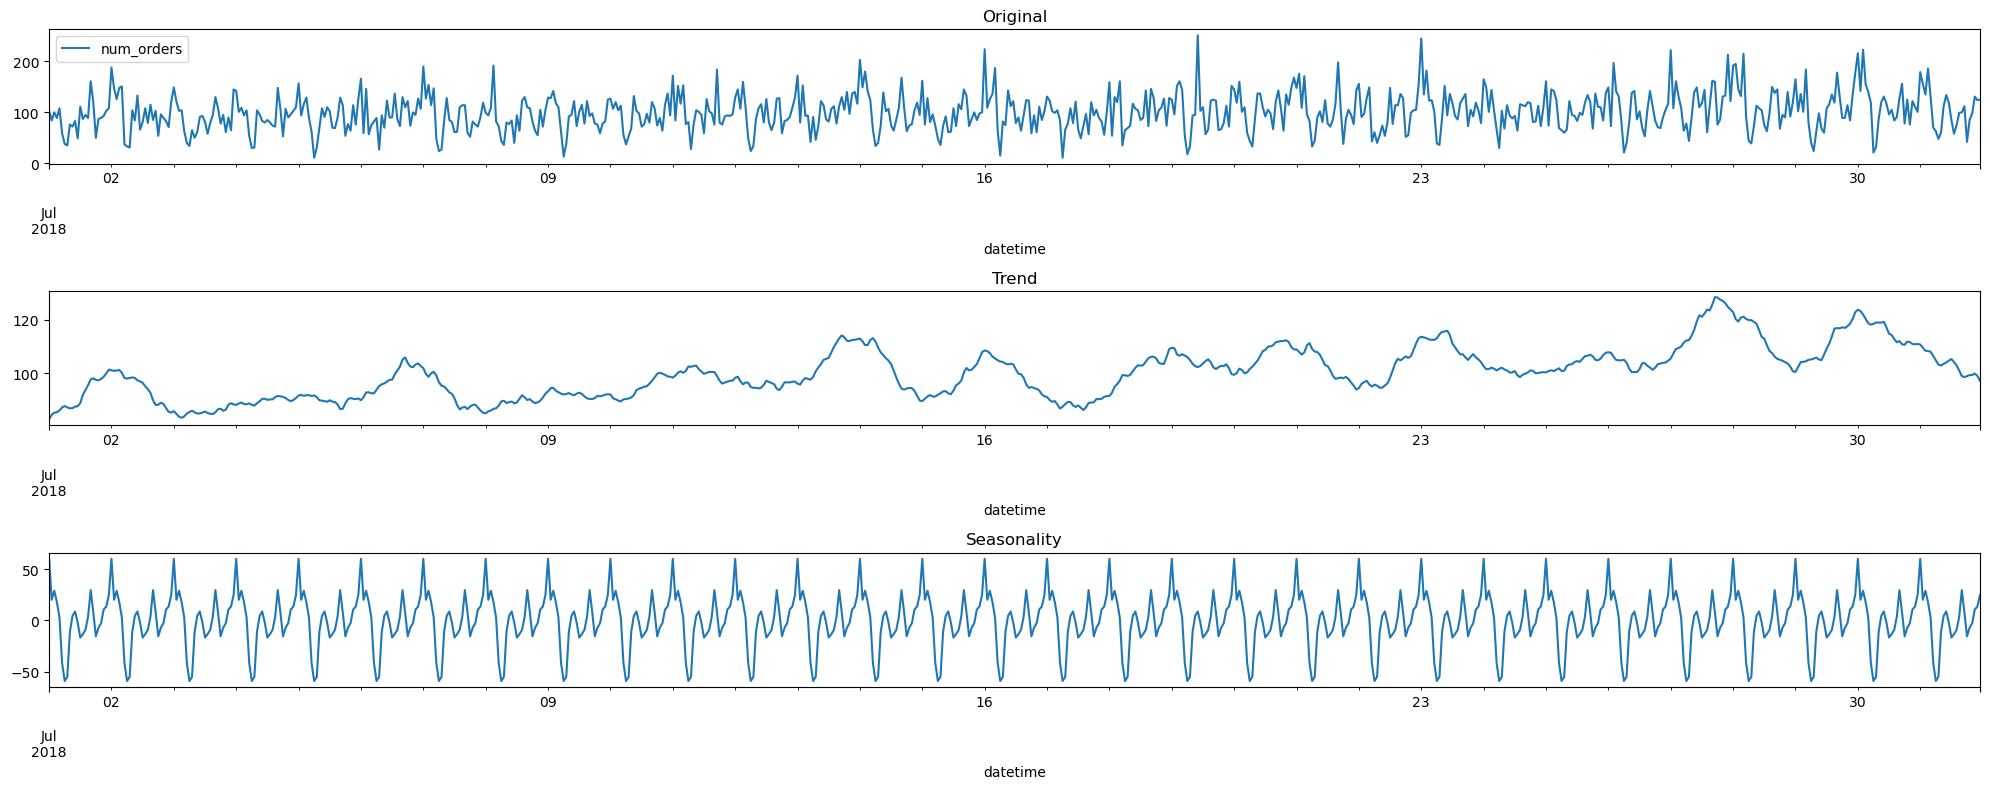

In [11]:
plot_decomposition('2018-07-01','2018-07-31')

### August Decomposition

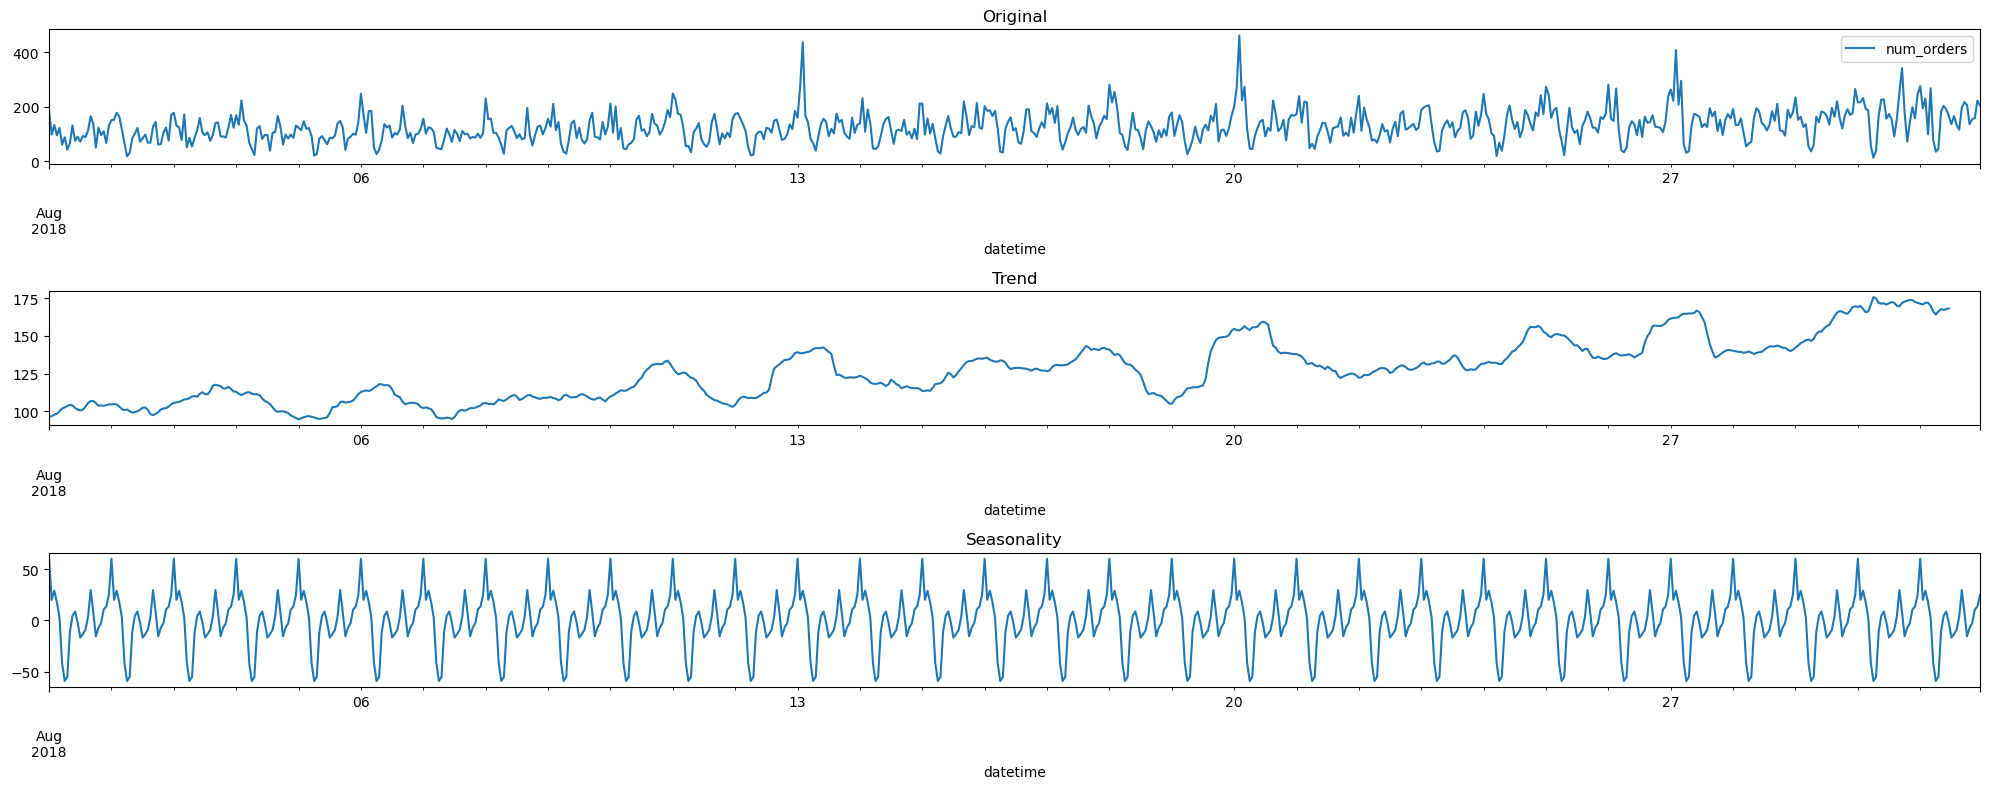

In [12]:
plot_decomposition('2018-08-01','2018-08-31')

Observing the trend and seasonality for each month reveals a clear pattern: the seasonality plot is consistent across all months, indicating a strong and recurring seasonal effect. Additionally, there is a noticeable upward trend as the months progress, highlighting a gradual increase over time.

## Splitting Data

We will split the data into 90% for training and 10% for testing, establishing a clear framework for model training and evaluation.

In [13]:
train, test = train_test_split(data_resampled, shuffle=False, test_size=0.1)

Next, we will determine the optimal number of lags using the training data to define the lag features in the dataset. The goal is to select a maximum lag value that balances capturing temporal dependencies without overly fragmenting the dataset.

In [14]:
mod = ar_select_order(endog=train, maxlag=100)
max_lag = mod.ar_lags[-1]
print("MAXIMUM LAG:", max_lag)

MAXIMUM LAG: 72


To enhance our data we will extract time-based features from the datetime index, including year, month, day, and day of the week, to capture seasonal patterns and temporal effects. Additionally, we will create lagged features to incorporate past values of the target variable, thereby capturing temporal dependencies in the data. Finally, we will calculate a rolling mean of the target variable over a specified window size, which helps in capturing short-term trends and providing a smoothing effect.

In [15]:
# Feature engineering data
def make_features(data, max_lag, rolling_mean_size):
    data = data.copy()
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

    return data.dropna()

# Feature engineer training data
train_enhanced = make_features(train, max_lag, rolling_mean_size)

# Feature engineer test data
test_enhanced = make_features(test, max_lag, rolling_mean_size)

We will now proceed with defining the features and target for the training data.

In [16]:
features_train = train_enhanced.drop(['num_orders'], axis=1)
target_train = train_enhanced['num_orders']

print("TRAINING DATA:")
print("--------------")
print("Features Training Set Size:", features_train.shape)
print(f"Features Training Set Range: {features_train.index.min()} - {features_train.index.max()}")
print()
print("Target Training Set Size:", target_train.shape)
print(f"Target Training Set Range: {target_train.index.min()} - {target_train.index.max()}")


TRAINING DATA:
--------------
Features Training Set Size: (3902, 77)
Features Training Set Range: 2018-03-04 00:00:00 - 2018-08-13 13:00:00

Target Training Set Size: (3902,)
Target Training Set Range: 2018-03-04 00:00:00 - 2018-08-13 13:00:00


And now the test data.

In [17]:
features_test = test_enhanced.drop(['num_orders'], axis=1)
target_test = test_enhanced['num_orders']

print("TEST DATA:")
print("----------")
print("Features Test Set Size:", features_test.shape)
print(f"Features Test Set Range: {features_test.index.min()} - {features_test.index.max()}")
print()
print("Target Test Set Size:", target_test.shape)
print(f"Target Test Set Range: {target_test.index.min()} - {target_test.index.max()}")

TEST DATA:
----------
Features Test Set Size: (370, 77)
Features Test Set Range: 2018-08-16 14:00:00 - 2018-08-31 23:00:00

Target Test Set Size: (370,)
Target Test Set Range: 2018-08-16 14:00:00 - 2018-08-31 23:00:00


We are now ready to proceed with model training and testing.

## Training & Testing

We will implement and evaluate a variety of models, including Linear Regression, Random Forest, and LightGBM, using RMSE (Root Mean Squared Error) as our primary evaluation metric. 

For optimizing the Random Forest and LightGBM models, we will leverage RandomizedSearchCV to fine-tune their hyperparameters. Additionally, we will plot the actual target values against the predicted values from these models to visually evaluate their accuracy and performance.

Finally, we will utilize Auto ARIMA to automatically identify the optimal ARIMA model for our dataset. We will evaluate this model's performance using RMSE and also visualize its effectiveness to gain a clear understanding of its forecasting accuracy.

In [18]:
# Plot actual target values against predictions
def plot_act_vs_pred(act_test, pred_test):

    plt.figure(figsize = (20, 8))

    # Plot the actual target values
    plt.plot(act_test.index, act_test, label = "Actual Target Values")

    # Plot the predicted target values
    plt.plot(act_test.index, pred_test, label = "Predicted Target Values")

    plt.title("Actual Target Values vs Predicted Target Values")
    plt.xlabel('Date')
    plt.ylabel('Number of Taxi Orders')
    plt.legend()
    plt.grid()
    plt.show()

### Linear Regression Model

LINEAR REGRESSION MODEL RMSE: 43.282021740984156


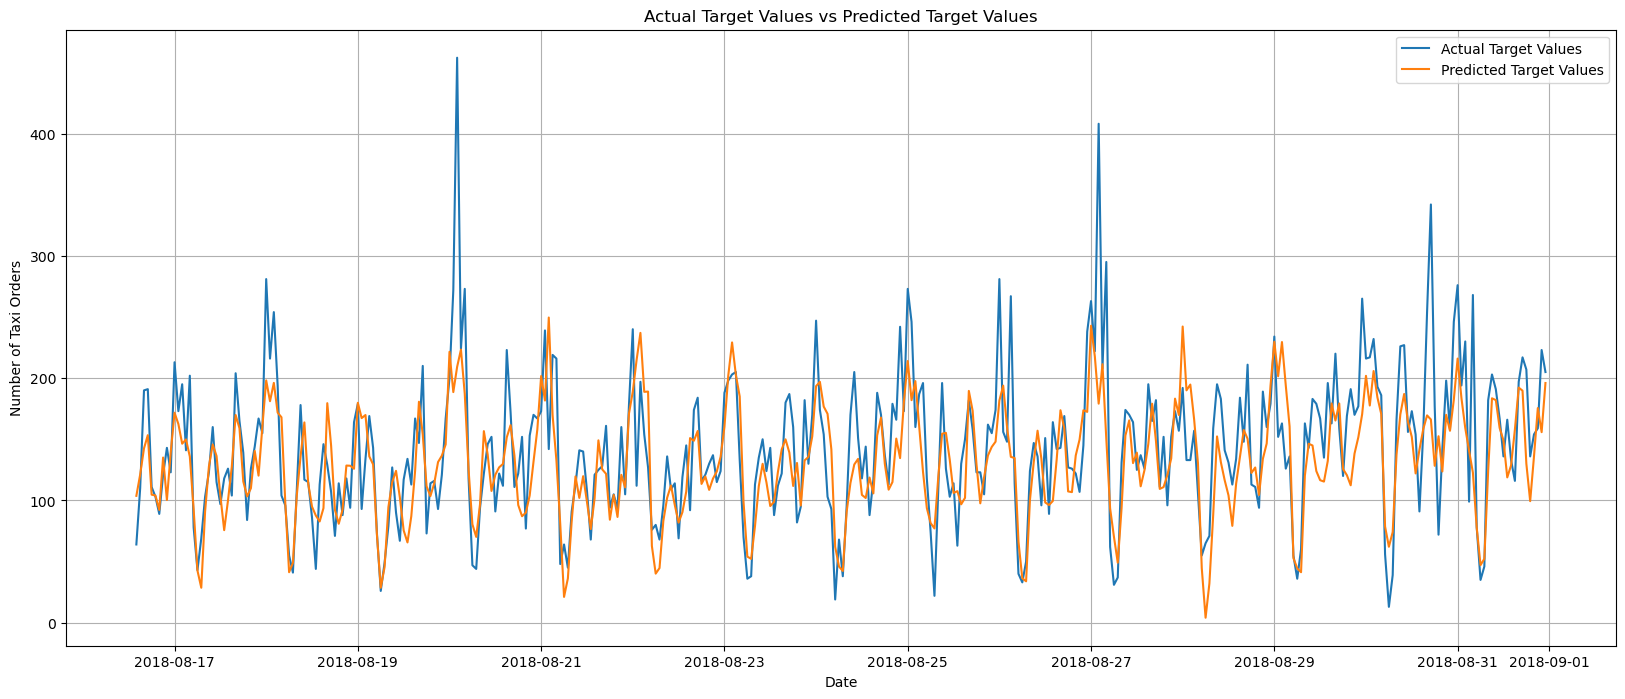

In [19]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model on the training data
lr_model.fit(features_train, target_train)

# Generate predictions on the test set
lr_pred_test = lr_model.predict(features_test)

# Calculate the RMSE of the predictions
lr_rmse = np.sqrt(mean_squared_error(target_test, lr_pred_test))

print("LINEAR REGRESSION MODEL RMSE:", lr_rmse) 

# Plot actual target values against predictions
plot_act_vs_pred(target_test, lr_pred_test)

### Random Forest Model

RANDOM FOREST MODEL RMSE: 44.77354382877333


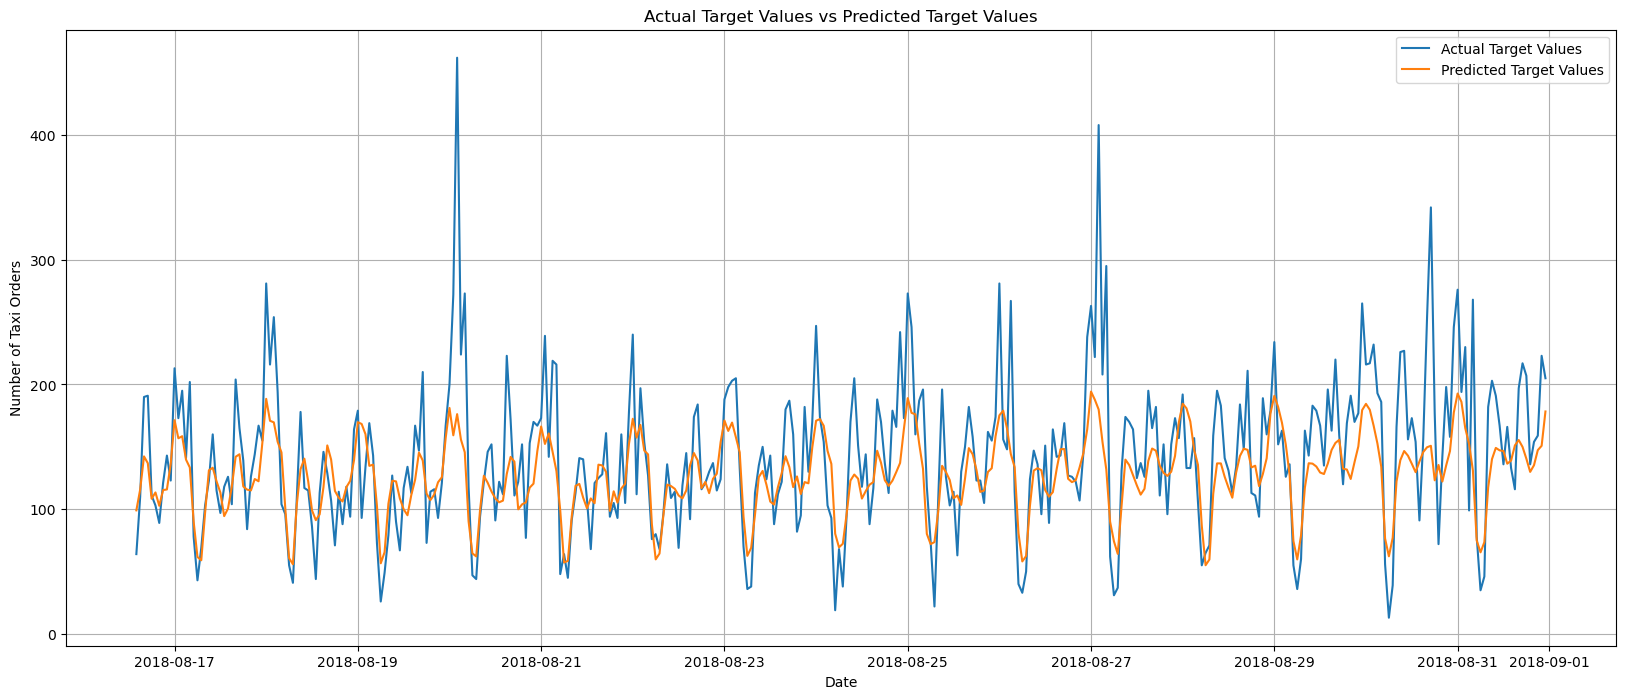

In [20]:
# Set up RandomizedSearchCV for tuning the Random Forest model
rf_random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=12345), 
    param_distributions={'n_estimators': [10, 50, 100, 200], 
                         'max_features': ['sqrt', 'log2'],
                         'max_depth': [None, 10, 20, 30, 40],
                         'min_samples_split': [2, 5, 10], 
                         'min_samples_leaf': [1, 2, 4]}, 
    n_iter=10,     
    cv=3,                        
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,                      
    random_state=12345
)

# Fit the RandomizedSearchCV object to the training data
rf_random_search.fit(features_train, target_train)

# Get the best Random Forest model from the search
rf_model = rf_random_search.best_estimator_

# Train the model on the training data
rf_model.fit(features_train, target_train)

# Generate predictions on the test set
rf_pred_test = rf_model.predict(features_test)

# Calculate the RMSE of the predictions
rf_rmse = np.sqrt(mean_squared_error(target_test, rf_pred_test))

print("RANDOM FOREST MODEL RMSE:", rf_rmse)

# Plot actual target values against predictions
plot_act_vs_pred(target_test, rf_pred_test)

### LightGBM Model

LIGHTGBM MODEL RMSE: 40.40517827852743


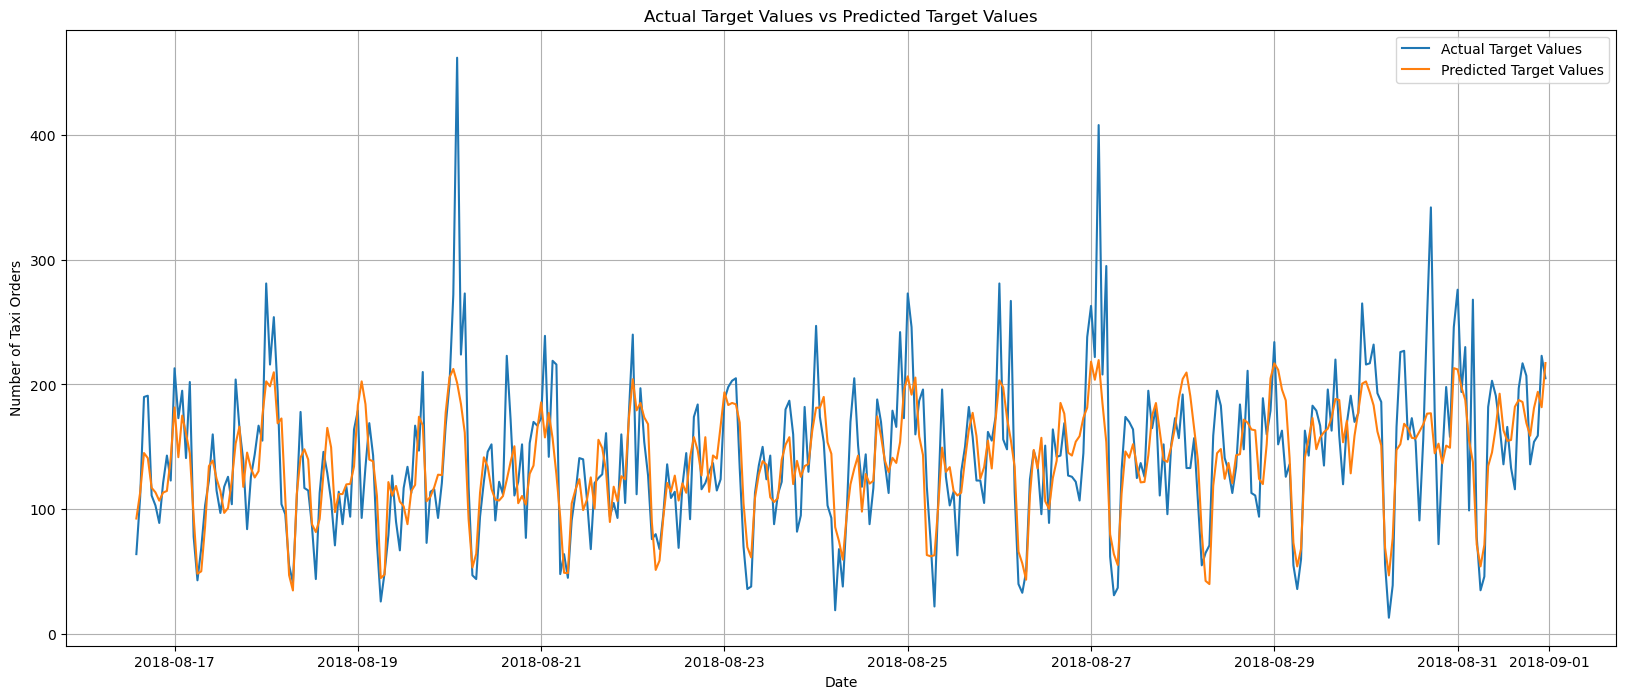

In [21]:
# Set up RandomizedSearchCV for tuning the LightGBM model
lgbm_random_search = RandomizedSearchCV(
    LGBMRegressor(random_state=12345, verbose=-1), 
    param_distributions={'num_leaves': [31, 50, 70],
                         'max_depth': [-1, 10, 20, 30],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'n_estimators': [50, 100, 200, 300],
                         'subsample': [0.6, 0.8, 1.0],
                         'colsample_bytree': [0.6, 0.8, 1.0],
                         'reg_alpha': [0, 0.1, 0.5, 1],
                         'reg_lambda': [0, 0.1, 0.5, 1]}, 
    n_iter=10,     
    cv=3,                        
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,                      
    random_state=12345
)

# Fit the RandomizedSearchCV object to the training data
lgbm_random_search.fit(features_train, target_train)

# Get the best LightGBM model from the search
lgbm_model = lgbm_random_search.best_estimator_

# Train the model on the training data
lgbm_model.fit(features_train, target_train)

# Generate predictions on the test set
lgbm_pred_test = lgbm_model.predict(features_test)

# Calculate the RMSE of the predictions
lgbm_rmse = np.sqrt(mean_squared_error(target_test, lgbm_pred_test))

print("LIGHTGBM MODEL RMSE:", lgbm_rmse)

# Plot actual target values against predictions
plot_act_vs_pred(target_test, lgbm_pred_test)

### Auto Arima

Before we proceed with using the Auto Arima tool, it is essential to determine whether the time series data is stationary. Stationarity is a key assumption for ARIMA models to perform effectively.

To assess stationarity, we will employ the Augmented Dickey-Fuller (ADF) test. If the p-value from the test is less than 0.05, we can confidently conclude that the dataset is likely stationary.

In [22]:
df_stationarityTest = adfuller(train, autolag='AIC')
print("P-VALUE: ", df_stationarityTest[1])

P-VALUE:  0.0007322730527364247


Given that the p-value is 0.000732, which is significantly less than the threshold of 0.05, we have strong reaon to belive that the time series data is stationary.

In [23]:
# Find optimal ARIMA model on the training data
auto_arima_model = auto_arima(train, seasonal=True, m=24, scoring='mse')

# Display summary of ARIMA model
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 3974
Model:             SARIMAX(5, 1, 0)x(1, 0, 0, 24)   Log Likelihood              -18908.217
Date:                            Sat, 10 Aug 2024   AIC                          37830.434
Time:                                    01:51:37   BIC                          37874.445
Sample:                                03-01-2018   HQIC                         37846.040
                                     - 08-13-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6335      0.012    -51.440      0.000      -0.658      -0.609
ar.L2         -0.4241      0.015    -27.550      0.000      -0.454      -0.394
ar.L3         -0.3002      0.016    -18.237      0.000      -0.333      -0.268
ar.L4         -0.2079      0.016    -12.875      0.000      -0.240      -0.176
ar.L5         -0.1125      0.015     -7.725      0.000      -0.141      -0.084
ar.S.L24       0.5767      0.013     45.159      0.000       0.552       0.602
sigma2       794.6419     12.135     65.482      0.000     770.857     818.427
===================================================================================
Ljung-Box (L1) (Q):                   1.45   Jarque-Bera (JB):              1081.50
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               2.16   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The Auto ARIMA tool identified that the SARIMAX model with the following parameters provided the best performance for the dataset:

ARIMA Part:
- p = 5: number of lag observations
- d = 1: number of differences applied to the series
- q = 0: size of moving average window

Seasonal Part:
- P = 1: number of seasonal autoregressive terms
- D = 0: number of seasonal differences applied to the series
- Q = 0: number of seasonal moving average terms
- s = 24: length of the seasonal cycle

We will now evaluate the SARIMAX model.

SARIMAX MODEL RMSE: 57.876113584640365


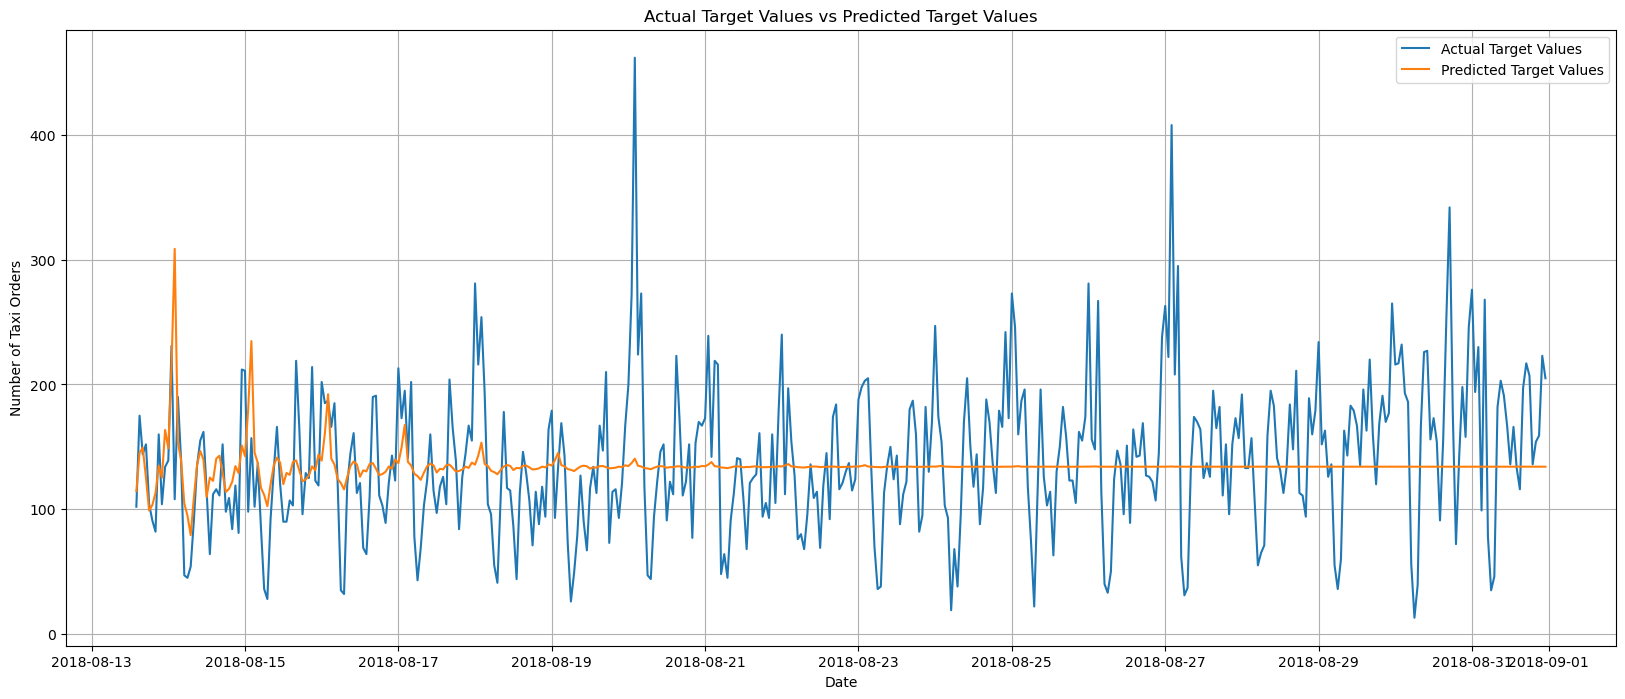

In [24]:
# Generate predictions on the test set
arima_pred_test = auto_arima_model.predict(len(test))

# Calculate the RMSE of the predictions
auto_arima_rmse = np.sqrt(mean_squared_error(test, arima_pred_test))

print("SARIMAX MODEL RMSE:", auto_arima_rmse)

# Plot actual target values against predictions
plot_act_vs_pred(test, arima_pred_test)

## Conclusion

In [25]:
model_analysis = pd.DataFrame({'Model': ['Linear Regression', 'Random Forest', 'LightGBM', 'SARIMAX'],
                                'RMSE': [lr_rmse, rf_rmse, lgbm_rmse, auto_arima_rmse]})

display(model_analysis)

,Model,RMSE
0,Linear Regression,43.282022
1,Random Forest,44.773544
2,LightGBM,40.405178
3,SARIMAX,57.876114


The Linear Regression, Random Forest, and LightGBM models all achieved RMSE scores below 48, indicating strong performance. Surprisingly, SARIMAX, despite being specifically designed for time series data, did not perform as well as the machine learning models on this dataset. This suggests that the time series components captured by SARIMAX may not have been as effective in this context, or that the dataset aligns better with the predictive patterns captured by models like Linear Regression, Random Forest, and LightGBM.

Overall, after analyzing the time series data provided by Sweet Lift Taxi, we observe a clear seasonality and an upward trend in the use of their taxi services at airports, particularly as it approaches August, likely driven by peak travel during the summer holidays and increased tourism.